**혹시나 코드를 실행할 일이 생길 땐 한번에 코드를 돌리지 말고 그래프 모듈 import부터는 그 위의 코드가 전부 돌아간 뒤에 돌려야 나눔고딕체가 제대로 사용됨.**



In [11]:
#필요한 모듈 import
import re
import lxml
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import math
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
"""
  날짜 문자열을 날짜로 변환하는 함수

  입력 값
    "2024-05-01"
    "2024-05-01 오전 12:05:47"
"""
def ConvertDate(in_date):

  list_date = re.split('[-: ]',in_date)

  intyear = int(list_date[0])
  intmonth = int(list_date[1])
  intday = int(list_date[2])
  inthour = 0
  intmin = 0
  intsec = 0

  if len(list_date) == 7:
    inthour = int(list_date[4])
    if list_date[3] == '오전':
      if inthour == 12:
        inthour = 0
    else:
      if inthour != 12:
        inthour = inthour + 12
    intmin = int(list_date[5])
    intsec = int(list_date[6])

  datevalue = datetime(year=intyear, month=intmonth, day=intday, hour=inthour, minute=intmin, second=intsec)
  return datevalue

"""
  서비스설명 : 장애인콜택시 이용 정보입니다. (Open API서비스는 최소 하루 전 데이터 요청만 가능합니다.)

  샘플URL
    장애인콜시스템
    http://openapi.seoul.go.kr:8088/(인증키)/xml/disabledCalltaxi/1/5/20210901

  요청인자
    변수명	    타입	        변수설명	        값설명
    KEY	        String(필수)	인증키	          OpenAPI 에서 발급된 인증키
    TYPE	      String(필수)	요청파일타입	    xml : xml
    SERVICE	    String(필수)	서비스명	        disabledCalltaxi
    START_INDEX	INTEGER(필수)	요청시작위치	    정수 입력 (페이징 시작번호 입니다 : 데이터 행 시작번호)
    END_INDEX	  INTEGER(필수)	요청종료위치	    정수 입력 (페이징 끝번호 입니다 : 데이터 행 끝번호)
    REG_DATE	  STRING(필수)	요청일

  출력값
    No	  출력명	          출력설명
    공통	list_total_count	총 데이터 건수 (정상조회 시 출력됨)
    공통	RESULT.CODE	      요청결과 코드 (하단 메세지설명 참고)
    공통	RESULT.MESSAGE	  요청결과 메시지 (하단 메세지설명 참고)
    1	    LIST_TOTAL_COUNT	총조회건수
    2	    RESULT.CODE	      결과코드
    3	    RESULT.MESSAGE	  메시지
    4	    NO	              차량고유번호
    5	    CARTYPE	          차량타입
    6	    RECEIPTIME	      예정일시
    7	    SETTIME	          배차일시
    8	    RIDETIME	        승차일시
    9	    STARTPOS1	        출발지구군
    10	  STARTPOS2	        출발지상세
    11	  ENDPOS1	          목적지구군
    12	  ENDPOS2	          목적지상세
"""
def findDisabledCallTaxi(findDate):
  service_key = '4f43556a6c6f666637346f4b456962'

  url = f'http://openapi.seoul.go.kr:8088/{service_key}/xml/disabledCalltaxi/1/100/'+findDate

  req = requests.get(url)
  soup = BeautifulSoup(req.text, 'html.parser')

  NOs = soup.find_all('no')
  CARTYPEs = soup.find_all('cartype')
  RECEIPTIMEs = soup.find_all('receipttime')
  SETTIMEs = soup.find_all('settime')
  RIDETIMEs = soup.find_all('ridetime')
  STARTPOS1s = soup.find_all('startpos1')
  STARTPSO2s = soup.find_all('startpos2')
  ENDPOS1s = soup.find_all('endpos1')
  ENDPOS2s = soup.find_all('endpos2')

  NO_list =[]
  CARTYPE_list =[]
  RECEIPTIME_list =[]
  SETTIME_list =[]
  RIDETIME_list =[]
  STARTPOS1_list =[]
  STARTPSO2_list =[]
  ENDPOS1_list =[]
  ENDPOS2_list =[]
  TIME1_list = []
  TIME2_list = []
  TIME3_list = []

  for NO,CARTYPE,RECEIPTIME,SETTIME,RIDETIME,STARTPOS1,STARTPSO2,ENDPOS1,ENDPOS2 in zip(NOs,CARTYPEs,RECEIPTIMEs,SETTIMEs,RIDETIMEs,STARTPOS1s,STARTPSO2s,ENDPOS1s,ENDPOS2s):
    # 'CARTYPE' 필드의 값이 없는 경우는 데이터로 인정하지 않는다.
    if CARTYPE.get_text() != '':

      # 'CARTYPE' 값을 정리 : '중형 승합', '중형승합', '중형승용', '대형 승용', '중형 승용', '대형승용', '중영 승용',
      cartype = CARTYPE.get_text()
      if cartype == '중형승합':
        cartype = '중형 승합'
      elif cartype == '중형승용':
        cartype = '중형 승용'
      elif cartype == '중영 승용':
        cartype = '중형 승용'
      elif cartype == '대형승용':
        cartype = '대형 승용'

      receiptime = ConvertDate(RECEIPTIME.get_text())
      settime = ConvertDate(SETTIME.get_text())
      ridetime = ConvertDate(RIDETIME.get_text())

      time1 = settime - receiptime
      time2 = ridetime - settime
      time3 = ridetime - receiptime

      # 시간 계산이 이전 시간인 경우 데이터 불인정
      if ridetime>=settime and settime >= receiptime:
        NO_list.append(NO.get_text())
        CARTYPE_list.append(cartype)
        RECEIPTIME_list.append(receiptime)
        SETTIME_list.append(settime)
        RIDETIME_list.append(ridetime)
        STARTPOS1_list.append(STARTPOS1.get_text())
        STARTPSO2_list.append(STARTPSO2.get_text())
        ENDPOS1_list.append(ENDPOS1.get_text())
        ENDPOS2_list.append(ENDPOS2.get_text())

        TIME1_list.append(time1)
        TIME2_list.append(time2)
        TIME3_list.append(time3)

  df = pd.DataFrame({
    'NO' : NO_list,
    'CARTYPE' : CARTYPE_list,
    'RECEIPTIME' : RECEIPTIME_list,
    'SETTIME' : SETTIME_list,
    'RIDETIME' : RIDETIME_list,
    'STARTPOS1' : STARTPOS1_list,
    'STARTPSO2' : STARTPSO2_list,
    'ENDPOS1' : ENDPOS1_list,
    'ENDPOS2' : ENDPOS2_list,
    'TIME1' : TIME1_list,
    'TIME2' : TIME2_list,
    'TIME3' : TIME3_list
  })

  return df

sDate = datetime(2024, 5, 1, 0, 0, 0)

for i in range(0,10):
  dt = sDate + timedelta(days=i)
  strDate = dt.strftime('%04Y%02m%02d')
  df = findDisabledCallTaxi(strDate)
  print("Date = ", strDate, " Count = ", df[['NO']].count(),"--------------------------------------------------")
  if i == 0:
    DisabledCallTaxi = df
  else:
    DisabledCallTaxi = pd.concat([DisabledCallTaxi, df])

/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240501  Count =  NO    2252
dtype: int64 --------------------------------------------------


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240502  Count =  NO    4825
dtype: int64 --------------------------------------------------


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240503  Count =  NO    4680
dtype: int64 --------------------------------------------------


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240504  Count =  NO    2033
dtype: int64 --------------------------------------------------


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240505  Count =  NO    1542
dtype: int64 --------------------------------------------------


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240506  Count =  NO    1571
dtype: int64 --------------------------------------------------


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240507  Count =  NO    4691
dtype: int64 --------------------------------------------------


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240508  Count =  NO    4693
dtype: int64 --------------------------------------------------


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240509  Count =  NO    4831
dtype: int64 --------------------------------------------------


/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


Date =  20240510  Count =  NO    4763
dtype: int64 --------------------------------------------------


In [3]:
DisabledCallTaxi['TIME1'] = round((DisabledCallTaxi['TIME1'].dt.seconds / 60),1)
DisabledCallTaxi['TIME2'] = round((DisabledCallTaxi['TIME2'].dt.seconds / 60),1)
DisabledCallTaxi['TIME3'] = round((DisabledCallTaxi['TIME3'].dt.seconds / 60),1)
DisabledCallTaxi
#TIME1: 예약 시간에서 배차까지의 시간
#TIME2: 배차 후 승객이 탑승하기까지의 시간
#TIME3: 탑승시간 - 예정시간 = 대기 시간

KeyError: 'TIME3'

In [13]:
DisabledCallTaxi.head()

,NO,CARTYPE,RECEIPTIME,SETTIME,RIDETIME,STARTPOS1,STARTPSO2,ENDPOS1,ENDPOS2,TIME1,TIME2,TIME3
0,8366,중형 승합,2024-05-01 00:00:00,2024-05-01 00:05:47,2024-05-01 00:38:37,종로구,종로1.2.3.4가동,광진구,광장동,5.8,32.8,38.6
1,8366,중형 승합,2024-05-01 00:00:00,2024-05-01 00:05:47,2024-05-01 00:38:37,종로구,종로1.2.3.4가동,광진구,광장동,5.8,32.8,38.6
2,9373,중형 승합,2024-05-01 00:06:00,2024-05-01 00:10:48,2024-05-01 00:28:09,마포구,망원제1동,서대문구,남가좌제2동,4.8,17.4,22.2
3,7843,중형 승합,2024-05-01 00:06:38,2024-05-01 00:49:05,2024-05-01 01:18:12,금천구,시흥제5동,금천구,시흥제2동,42.4,29.1,71.6
4,5799,중형 승합,2024-05-01 00:30:11,2024-05-01 00:37:32,2024-05-01 01:08:30,서초구,반포4동,강남구,수서동,7.4,31.0,38.3


In [14]:
DisabledCallTaxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35881 entries, 0 to 4762
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   NO          35881 non-null  object        
 1   CARTYPE     35881 non-null  object        
 2   RECEIPTIME  35881 non-null  datetime64[ns]
 3   SETTIME     35881 non-null  datetime64[ns]
 4   RIDETIME    35881 non-null  datetime64[ns]
 5   STARTPOS1   35881 non-null  object        
 6   STARTPSO2   35881 non-null  object        
 7   ENDPOS1     35881 non-null  object        
 8   ENDPOS2     35881 non-null  object        
 9   TIME1       35881 non-null  float64       
 10  TIME2       35881 non-null  float64       
 11  TIME3       35881 non-null  float64       
dtypes: datetime64[ns](3), float64(3), object(6)
memory usage: 3.6+ MB


<Axes: >

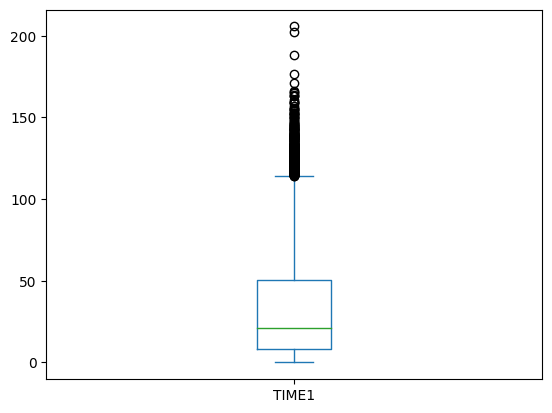

In [ ]:
#TIME1 Box plot
DisabledCallTaxi['TIME1'].plot(kind='box')

<Axes: >

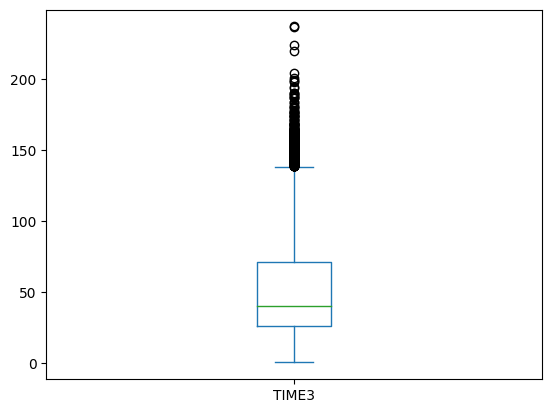

In [ ]:
#TIME3 Box plot
DisabledCallTaxi['TIME3'].plot(kind='box')

In [ ]:
DisabledCallTaxi['CARTYPE'].unique()

array(['중형 승합', '중형 승용', '대형 승용'], dtype=object)

In [ ]:
#TIME1 최댓값(최솟값과 비교용)
pos_max  = DisabledCallTaxi.groupby('STARTPOS1')['TIME1'].max()
print(pos_max)

STARTPOS1
강남구       143.4
강동구       130.1
강북구       144.7
강서구       176.9
관악구       188.4
광명시        48.9
광진구       160.6
구로구       163.3
구리시        41.0
금천구       155.3
김포시        44.8
노원구       152.0
도봉구       142.2
동대문구      156.0
동작구       143.7
마포구       152.6
서대문구      205.7
서초구       165.4
성남시분당구      0.1
성남시수정구      0.7
성동구       139.3
성북구       154.9
송파구       153.9
양주시         1.0
양천구       148.4
영등포구      163.5
용산구       159.4
은평구       171.2
종로구       154.1
중구        143.9
중랑구       166.0
하남시        63.9
Name: TIME1, dtype: float64


In [ ]:
DisabledCallTaxi['TIME1'].max()

205.7

In [ ]:
DisabledCallTaxi['TIME3'].max()

237.2

In [ ]:
DisabledCallTaxi['TIME3'].mean()

51.15069535408713

In [ ]:
DisabledCallTaxi['TIME3'].std()

32.44679503352141

In [ ]:
DisabledCallTaxi['TIME3'].median()

40.3

In [ ]:
DisabledCallTaxi['TIME3'].min()

0.4

In [ ]:
#TIME1 최솟값(최댓값과 비교용)
pos_min  = DisabledCallTaxi.groupby('STARTPOS1')['TIME1'].min()
print(pos_min)

STARTPOS1
강남구        0.1
강동구        0.2
강북구        0.2
강서구        0.4
관악구        0.5
광명시        5.2
광진구        0.2
구로구        0.5
구리시       41.0
금천구        0.7
김포시        2.0
노원구        0.0
도봉구        0.4
동대문구       0.2
동작구        0.6
마포구        0.1
서대문구       0.0
서초구        0.3
성남시분당구     0.1
성남시수정구     0.7
성동구        0.3
성북구        0.0
송파구        0.2
양주시        1.0
양천구        0.3
영등포구       0.3
용산구        0.2
은평구        0.0
종로구        0.4
중구         0.6
중랑구        0.2
하남시        3.8
Name: TIME1, dtype: float64


In [ ]:
#각 구 당 이용횟수를 나타낸 dataframe
topSTARTPOS1 = DisabledCallTaxi['STARTPOS1'].value_counts().to_frame()
print(topSTARTPOS1)

           count
STARTPOS1       
노원구         3859
강서구         2437
서대문구        2051
은평구         2045
마포구         2027
강동구         1971
송파구         1577
강남구         1488
영등포구        1426
동대문구        1415
중랑구         1381
양천구         1333
구로구         1305
관악구         1277
성북구         1231
도봉구         1217
강북구         1152
종로구         1119
광진구         1014
동작구          973
서초구          969
성동구          815
용산구          652
금천구          603
중구           524
광명시            7
하남시            5
김포시            3
성남시분당구         2
구리시            1
양주시            1
성남시수정구         1


In [ ]:
#서울 외엔 표본이 너무 적어 바로 위에서 서울시만 포함시킨 dataframe
topSTARTPOS1_slec = topSTARTPOS1.iloc[:25]
print(topSTARTPOS1_slec)

           count
STARTPOS1       
노원구         3859
강서구         2437
서대문구        2051
은평구         2045
마포구         2027
강동구         1971
송파구         1577
강남구         1488
영등포구        1426
동대문구        1415
중랑구         1381
양천구         1333
구로구         1305
관악구         1277
성북구         1231
도봉구         1217
강북구         1152
종로구         1119
광진구         1014
동작구          973
서초구          969
성동구          815
용산구          652
금천구          603
중구           524


In [ ]:
#5/1 ~ 5/10 동안 운행된 차량의 개수(2-1 운행차량 개수 증가 제안 시 사용 가능할지도?)
NO = DisabledCallTaxi['NO'].value_counts()
print(len(NO))

752


In [8]:
#그래프 그릴 떄 필요한 모듈 import
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl
fm.fontManager.ttflist

[FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'),
 FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'),
 FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'),
 FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable'),
 FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', 

In [1]:
#나눔고딕체를 사용하기 위해 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (4,051 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and dire

In [ ]:
#글씨체, 크기 설정과 수평 막대 그래프 그리는 함수
plt.rcParams["font.family"]= "NanumGothic"
plt.rcParams["font.size"]= 7
def barh_graph(Data, title, x_label, y_label, color = 'skyblue', rotation = 0):
  plt.figure(figsize=(12, 8))
  Data.plot(kind = 'barh', color= color)
  plt.title(title)
  plt.xlabel(x_label)
  plt.xticks(rotation=rotation)
  plt.ylabel(y_label)
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

<Figure size 1200x800 with 0 Axes>

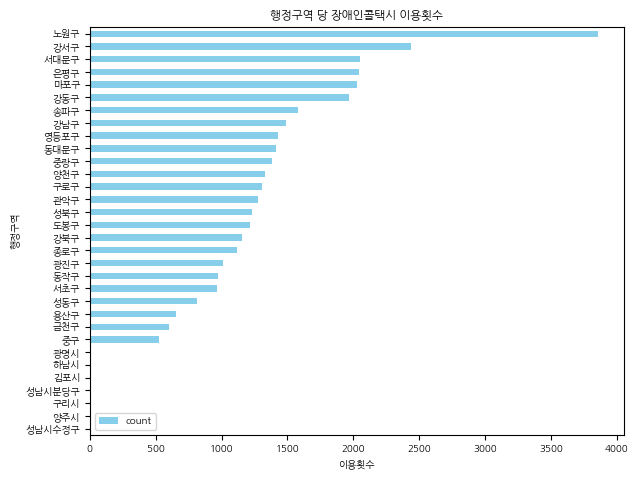

In [ ]:
#topSTARTPOS1 그래프
barh_graph(topSTARTPOS1, '행정구역 당 장애인콜택시 이용횟수', '이용횟수', '행정구역')

<Figure size 1200x800 with 0 Axes>

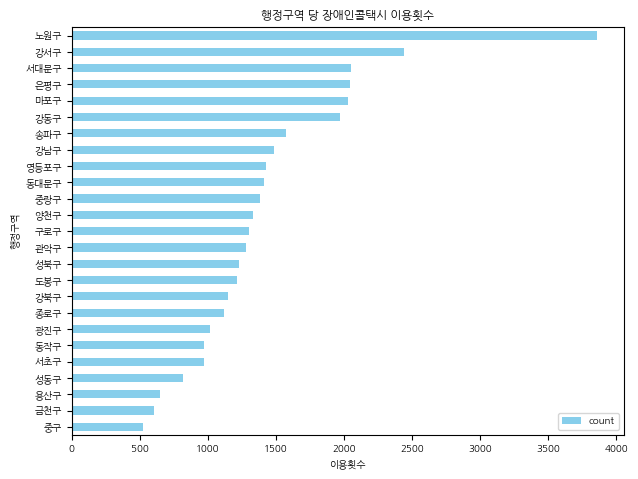

In [ ]:
#topSTARTPOS1 그래프(서울시만 포함)
barh_graph(topSTARTPOS1_slec, '행정구역 당 장애인콜택시 이용횟수', '이용횟수', '행정구역')

In [ ]:
#TIME1 평균 그래프. 필요 시 아래 셀과 함께 사용
#pos_mean = DisabledCallTaxi.groupby('STARTPOS1')['TIME1'].mean().sort_values(ascending=False)
# print(pos_mean)

In [ ]:
#barh_graph(pos_mean, '행정구역 당 평균 장애인콜택시 대기시간', '행정구역', '대기시간(분)')

In [ ]:
#TIME1(서울만 포함) 평균 그래프. 필요 시 아래 셀과 함께 사용
pos_mean_slec = DisabledCallTaxi.groupby('STARTPOS1')['TIME1'].mean().sort_values(ascending=False)
pos_mean_slec = pos_mean_slec.drop(['광명시', '하남시', '김포시', '성남시분당구', '구리시', '양주시', '성남시수정구'])

print(pos_mean_slec)

STARTPOS1
서초구     39.143034
금천구     38.815091
서대문구    37.459044
관악구     36.984886
용산구     36.624233
은평구     36.421076
구로구     35.915172
성동구     35.198282
강남구     33.602487
영등포구    33.253436
동작구     33.129599
마포구     32.862802
성북구     32.677335
강서구     32.178006
종로구     31.628239
송파구     31.281103
광진구     30.956903
중구      30.931679
강동구     30.469711
강북구     29.499045
동대문구    29.014417
양천구     28.732708
도봉구     27.980937
노원구     27.379554
중랑구     27.197031
Name: TIME1, dtype: float64


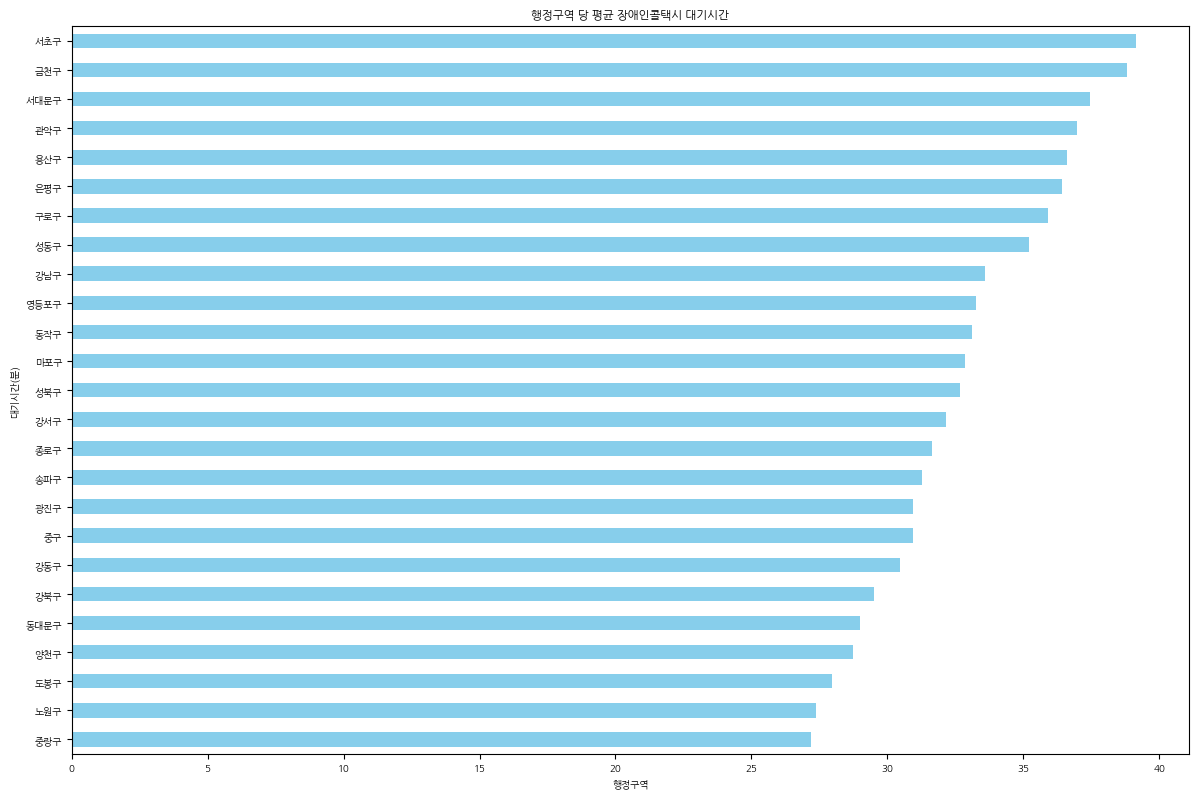

In [ ]:
barh_graph(pos_mean_slec, '행정구역 당 평균 장애인콜택시 대기시간', '행정구역', '대기시간(분)')

In [ ]:
#TIME1 중간값 그래프. 필요시 아래 셀과 함께 사용
pos_median = DisabledCallTaxi.groupby('STARTPOS1')['TIME1'].median().sort_values(ascending = False)
print(pos_median)

STARTPOS1
하남시       46.30
구리시       41.00
서초구       31.40
용산구       28.60
은평구       28.20
광명시       27.60
성동구       27.10
관악구       27.00
서대문구      25.30
강남구       24.45
금천구       24.20
마포구       23.50
성북구       23.20
강동구       23.20
영등포구      22.70
송파구       22.40
구로구       22.10
동작구       21.80
종로구       21.10
광진구       20.60
강서구       20.50
중구        20.10
동대문구      17.50
도봉구       17.10
강북구       16.85
양천구       16.10
노원구       15.80
중랑구       14.80
김포시        8.60
양주시        1.00
성남시수정구     0.70
성남시분당구     0.10
Name: TIME1, dtype: float64


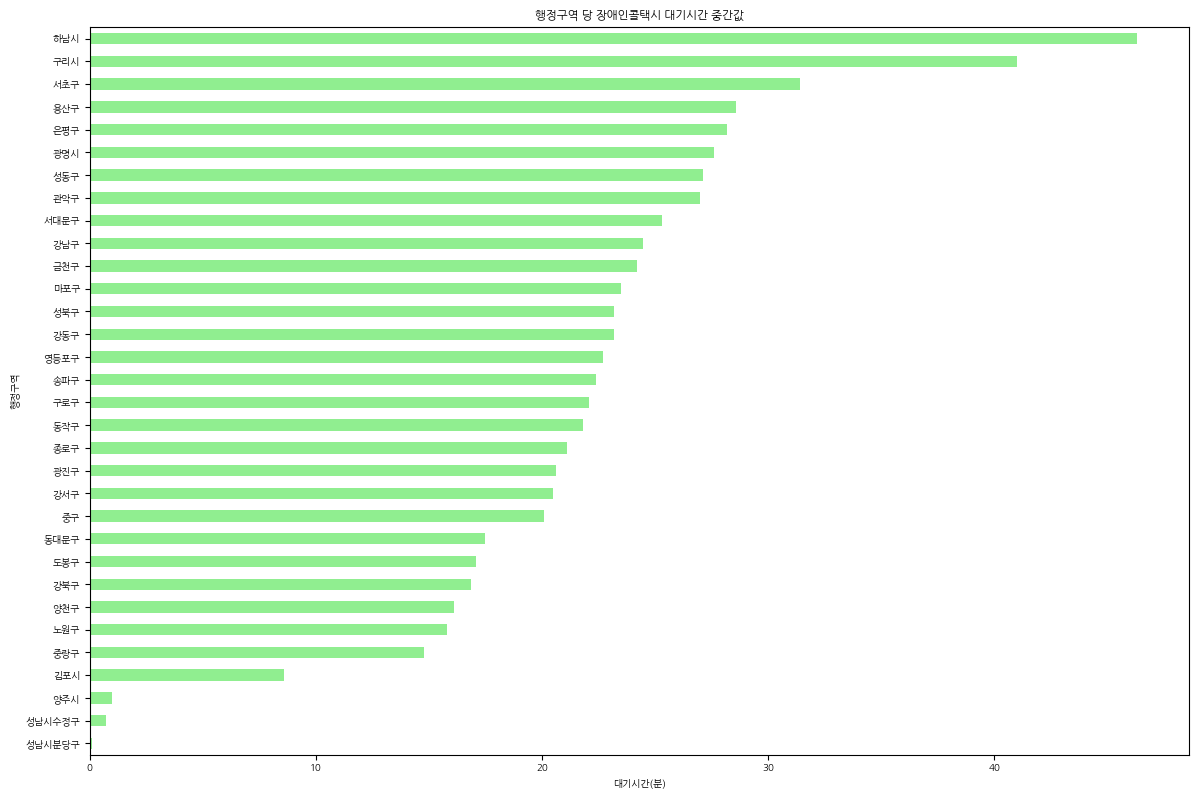

In [ ]:
barh_graph(pos_median, '행정구역 당 장애인콜택시 대기시간 중간값', '대기시간(분)', '행정구역', 'lightgreen')

In [ ]:
#TIME1 중간값 그래프(서울만 포함). 필요시 아래 셀과 함께 사용
pos_median = DisabledCallTaxi.groupby('STARTPOS1')['TIME1'].median().sort_values(ascending=False)
pos_median_slec = pos_median.drop(['광명시', '하남시', '김포시', '성남시분당구', '구리시', '양주시', '성남시수정구'])
print(pos_median_slec)

STARTPOS1
서초구     31.40
용산구     28.60
은평구     28.20
성동구     27.10
관악구     27.00
서대문구    25.30
강남구     24.45
금천구     24.20
마포구     23.50
성북구     23.20
강동구     23.20
영등포구    22.70
송파구     22.40
구로구     22.10
동작구     21.80
종로구     21.10
광진구     20.60
강서구     20.50
중구      20.10
동대문구    17.50
도봉구     17.10
강북구     16.85
양천구     16.10
노원구     15.80
중랑구     14.80
Name: TIME1, dtype: float64


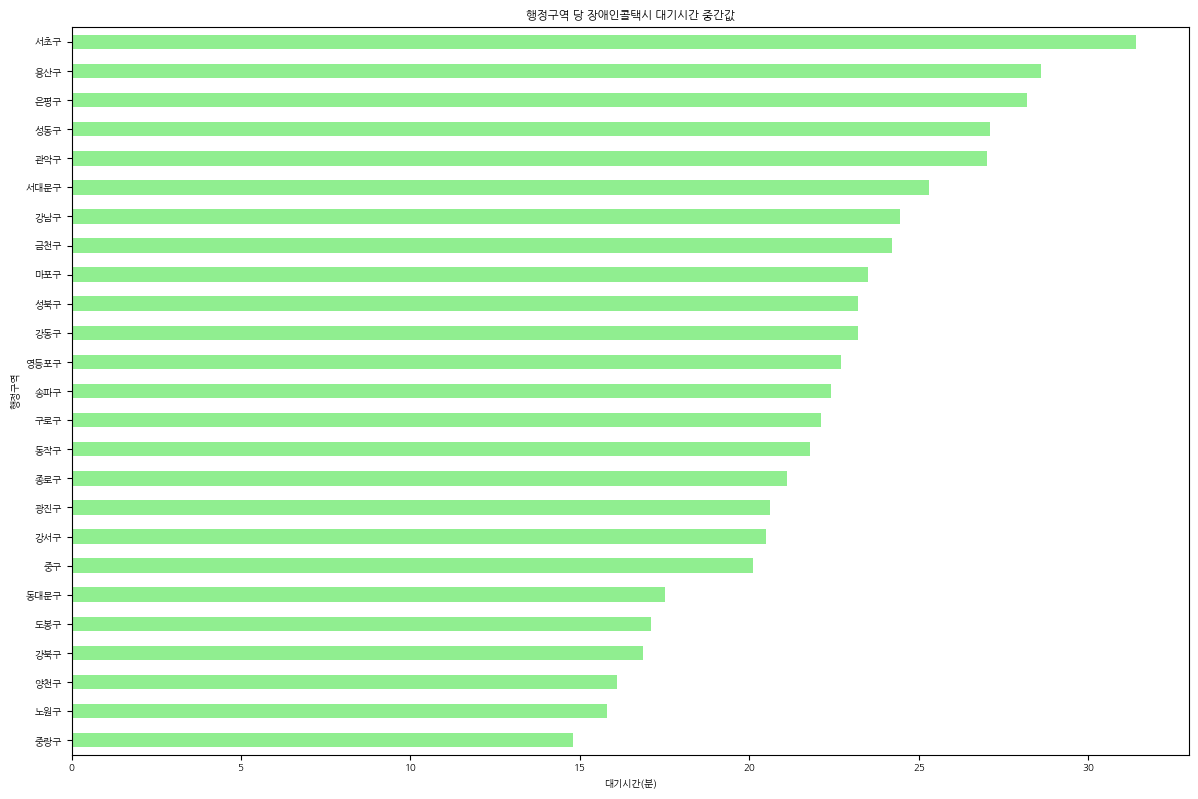

In [ ]:
barh_graph(pos_median_slec, '행정구역 당 장애인콜택시 대기시간 중간값', '대기시간(분)', '행정구역', 'lightgreen')

In [ ]:
#중간값 역순정렬, 필요시 아래 셀과 함꼐 사용
pos_median_reverse = DisabledCallTaxi.groupby('STARTPOS1')['TIME1'].median().sort_values(ascending=True)
print(pos_median_reverse)

STARTPOS1
성남시분당구     0.10
성남시수정구     0.70
양주시        1.00
김포시        8.60
중랑구       14.80
노원구       15.80
양천구       16.10
강북구       16.85
도봉구       17.10
동대문구      17.50
중구        20.10
강서구       20.50
광진구       20.60
종로구       21.10
동작구       21.80
구로구       22.10
송파구       22.40
영등포구      22.70
성북구       23.20
강동구       23.20
마포구       23.50
금천구       24.20
강남구       24.45
서대문구      25.30
관악구       27.00
성동구       27.10
광명시       27.60
은평구       28.20
용산구       28.60
서초구       31.40
구리시       41.00
하남시       46.30
Name: TIME1, dtype: float64


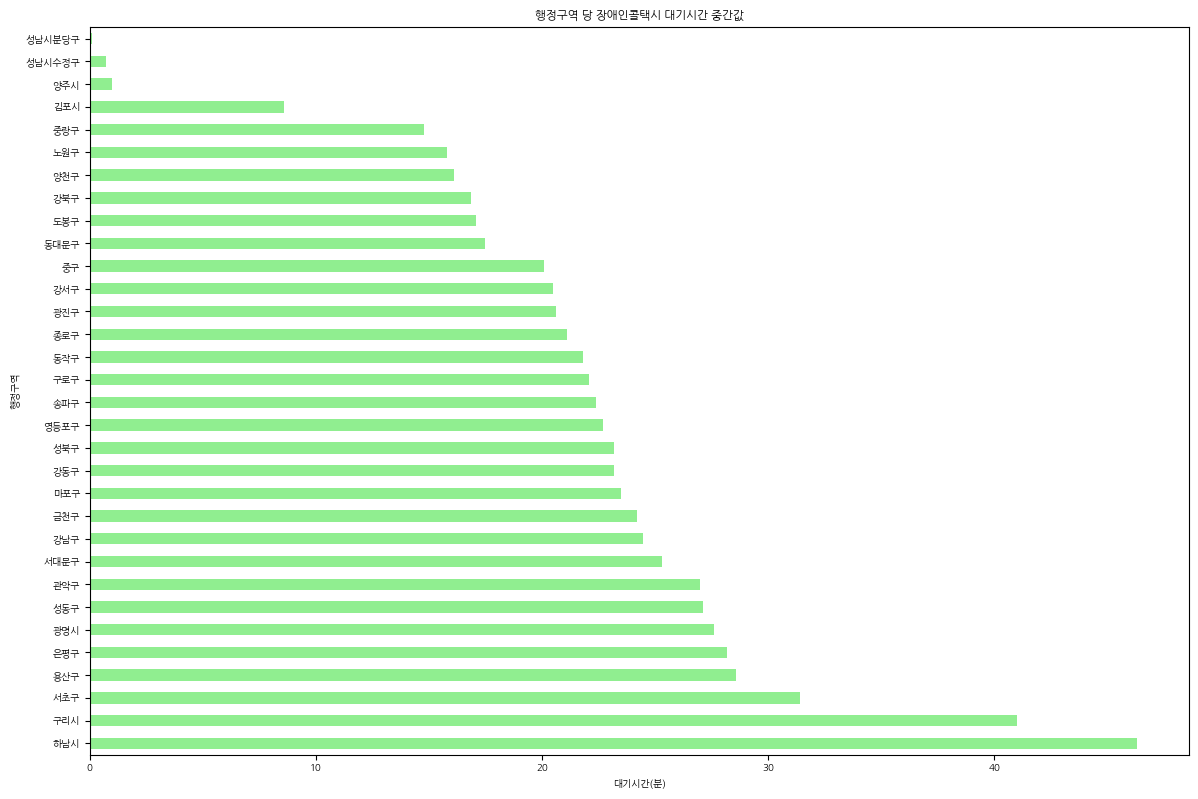

In [ ]:
barh_graph(pos_median_reverse, '행정구역 당 장애인콜택시 대기시간 중간값', '대기시간(분)', '행정구역', 'lightgreen')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<Figure size 1200x800 with 0 Axes>

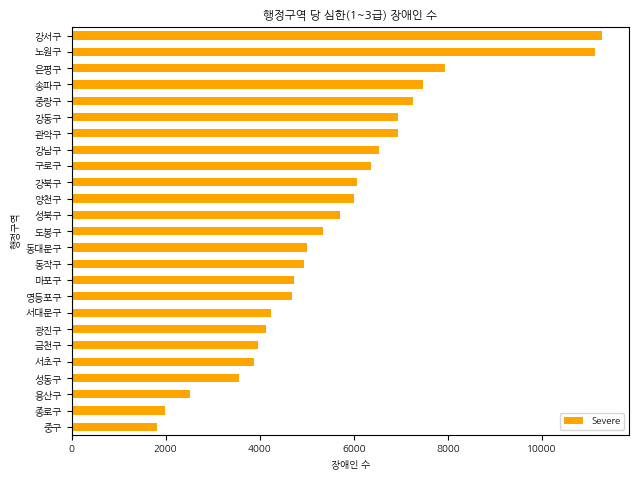

In [ ]:
#행정구역 당 심한(1~3급) 장애인 수. 장애인콜택시를 이용할 수 있는 기준이 보행상 장애가 있는 1~3 급 장애인이기에 심한 장애(기존 1~3급)를 가진 사람 수만 빼서 이용.
#https://www.sisul.or.kr/open_content/calltaxi/introduce/receipt.jsp 참고
file_path = '/content/장애인+현황(등급별_동별)_20240527184129.xlsx'
excel_data = pd.ExcelFile(file_path)


data_df = pd.read_excel(file_path, sheet_name='데이터')

# 데이터만 남기고 열 이름 만들기
data_df_cleaned = data_df.drop([0, 1, 2])
data_df_cleaned.columns = ['Region1', 'Region2', 'Total', 'Male', 'Female', 'Severe', 'Severe_Male', 'Severe_Female', 'Non_Severe', 'Non_Severe_Male', 'Non_Severe_Female']

# index 초기화
data_df_cleaned.reset_index(drop=True, inplace=True)

#필요한 데이터만 뽑아서 그래프 그리기
data_df_cleaned = data_df_cleaned.dropna(subset=['Region2'])
data_df_cleaned = data_df_cleaned[data_df_cleaned['Region2'] != '소계']
data_df_sorted = data_df_cleaned.sort_values(by='Severe', ascending=False)
severe = data_df_sorted[['Region2', 'Severe']].set_index('Region2')
barh_graph(severe, '행정구역 당 심한(1~3급) 장애인 수', '장애인 수', '행정구역', 'orange')

In [ ]:
severe.min()

Severe    1827
dtype: object

In [ ]:
#행정구역을 기준으로 join
df_join = topSTARTPOS1_slec.join(severe)
df_join.head()

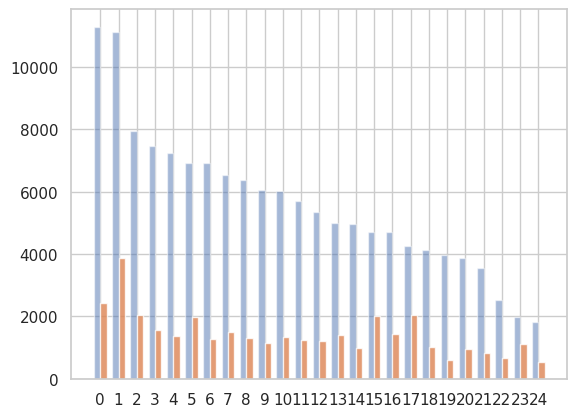

In [ ]:
x = np.arange(len(df_join['Severe']))
y_1 = df_join['Severe']
y_2 = df_join['count']

# 넓이 지정
width = 0.35

# subplots 생성
fig, axes = plt.subplots()

# 넓이 설정
axes.bar(x - width/2, y_1, width, align='center', alpha=0.5)
axes.bar(x + width/2, y_2, width, align='center', alpha=0.8)

# xtick 설정
plt.xticks(x)

plt.show()

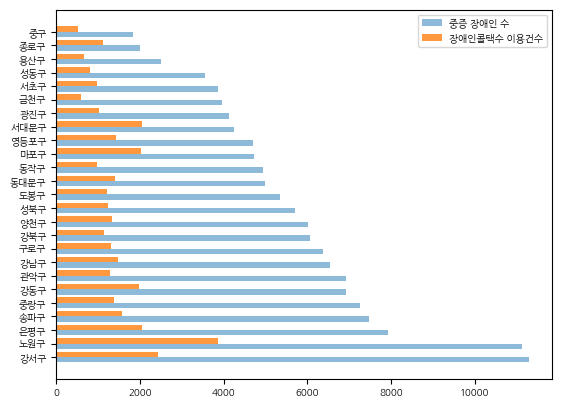

In [ ]:
x_label = ['강서구', '노원구', '은평구', '송파구', '중랑구', '강동구', '관악구', '강남구', '구로구', '강북구',
       '양천구', '성북구', '도봉구', '동대문구', '동작구', '마포구', '영등포구', '서대문구', '광진구', '금천구',
       '서초구', '성동구', '용산구', '종로구', '중구']
x = np.arange(len(df_join['Severe']))
y_1 = df_join['Severe']
y_2 = df_join['count']

# 넓이 지정
width = 0.4

# subplots 생성
fig, axes = plt.subplots()

# 넓이 설정
axes.barh(x - width/2, y_1, width, align='center', alpha=0.5)
axes.barh(x + width/2, y_2, width, align='center', alpha=0.8)

# xtick 설정
plt.yticks(x)
axes.set_yticklabels(x_label)

plt.legend(['중증 장애인 수', '장애인콜택수 이용건수'])

plt.show()

In [ ]:
df_join.head()

,count,Severe
STARTPOS1,,
노원구,3859,11132
강서구,2437,11290
서대문구,2051,4248
은평구,2045,7937
마포구,2027,4724


In [ ]:
df_join2.head()

,count,TIME1
STARTPOS1,,
노원구,3859,15.8
강서구,2437,20.5
서대문구,2051,25.3
은평구,2045,28.2
마포구,2027,23.5


In [ ]:
df_joining = df_join.drop(['count'], axis=1)
df_join3 = df_joining.merge(df_join2, on='STARTPOS1')

df_join3.head()

,Severe,count,TIME1
STARTPOS1,,,
노원구,11132,3859,15.8
강서구,11290,2437,20.5
서대문구,4248,2051,25.3
은평구,7937,2045,28.2
마포구,4724,2027,23.5


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


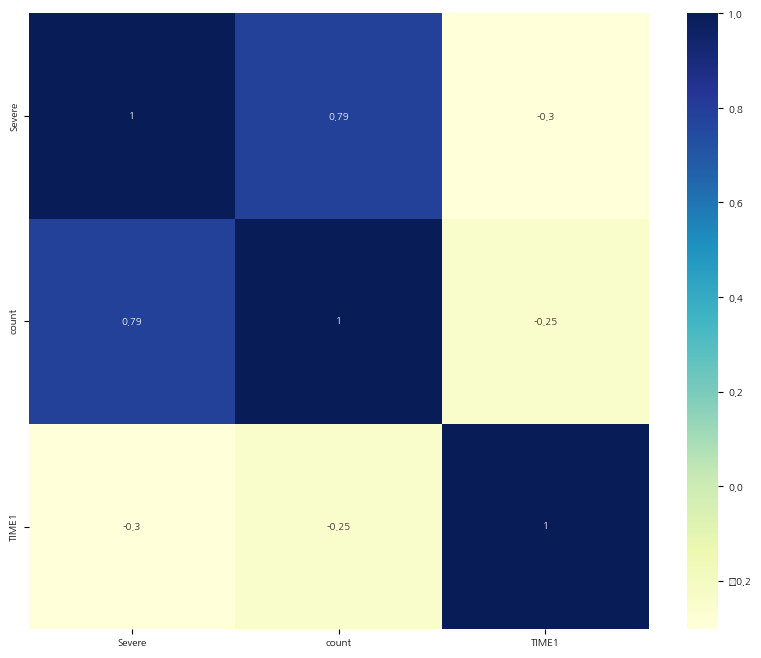

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_join3.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [ ]:
df_join2 = topSTARTPOS1_slec.join(pos_median_slec)
df_join2.head()

,count,TIME1
STARTPOS1,,
노원구,3859,15.8
강서구,2437,20.5
서대문구,2051,25.3
은평구,2045,28.2
마포구,2027,23.5


In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

train_minmax = minmax_scaler.fit_transform(df_join2)
train_minmax = pd.DataFrame(train_minmax,
                            index=df_join2.index,
                            columns=df_join2.columns)
train_minmax.head()

,count,TIME1
STARTPOS1,,
노원구,1.000000,0.060241
강서구,0.573613,0.343373
서대문구,0.457871,0.632530
은평구,0.456072,0.807229
마포구,0.450675,0.524096


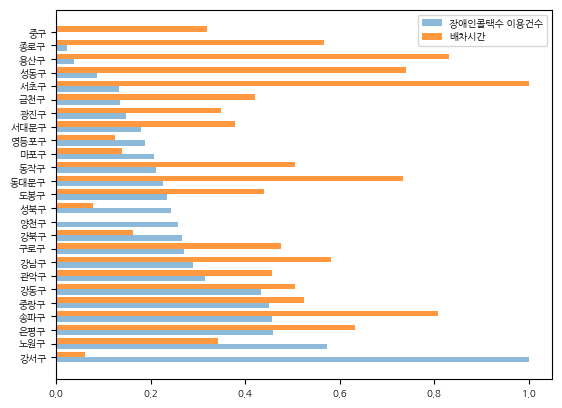

In [ ]:
x_label = ['강서구', '노원구', '은평구', '송파구', '중랑구', '강동구', '관악구', '강남구', '구로구', '강북구',
       '양천구', '성북구', '도봉구', '동대문구', '동작구', '마포구', '영등포구', '서대문구', '광진구', '금천구',
       '서초구', '성동구', '용산구', '종로구', '중구']
x = np.arange(len(train_minmax['TIME1']))
y_1 = train_minmax['count']
y_2 = train_minmax['TIME1']

# 넓이 지정
width = 0.4

# subplots 생성
fig, axes = plt.subplots()

# 넓이 설정
axes.barh(x - width/2, y_1, width, align='center', alpha=0.5)
axes.barh(x + width/2, y_2, width, align='center', alpha=0.8)

# xtick 설정
plt.yticks(x)
axes.set_yticklabels(x_label)

plt.legend(['장애인콜택수 이용건수', '배차시간'])

plt.show()

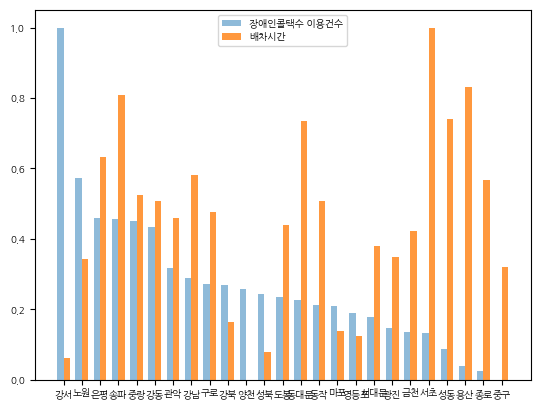

In [ ]:
x_label = ['강서', '노원', '은평', '송파', '중랑', '강동', '관악', '강남', '구로', '강북',
       '양천', '성북', '도봉', '동대문', '동작', '마포', '영등포', '서대문', '광진', '금천',
       '서초', '성동', '용산', '종로', '중구']
x = np.arange(len(train_minmax['TIME1']))
y_1 = train_minmax['count']
y_2 = train_minmax['TIME1']

# 넓이 지정
width = 0.35

# subplots 생성
fig, axes = plt.subplots()

# 넓이 설정
axes.bar(x - width/2, y_1, width, align='center', alpha=0.5)
axes.bar(x + width/2, y_2, width, align='center', alpha=0.8)

# xtick 설정
plt.xticks(x)
axes.set_xticklabels(x_label)
plt.legend(['장애인콜택수 이용건수', '배차시간'])

plt.show()